In [26]:
# Use logistic regression to predict adult incomes
# Data resource: Kaggle (https://www.kaggle.com/flyingwombat/logistic-regression-with-uci-adult-income/data)

In [27]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cross_validation as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [28]:
# Load local csv data into pandas DataFrame
income_df = pd.read_csv("data/income_data.csv")
income_df_list =  list(income_df)
print income_df_list
print income_df.shape

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
(48842, 15)


In [29]:
income_df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
735,32,Private,160458,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
17090,20,Private,138768,HS-grad,9,Never-married,Transport-moving,Own-child,White,Male,0,0,30,United-States,<=50K
48,52,Private,201062,11th,7,Separated,Priv-house-serv,Not-in-family,Black,Female,0,0,18,United-States,<=50K
31906,66,Local-gov,36364,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,2267,40,United-States,<=50K
33123,30,Private,235639,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


In [30]:
# get some basic ideas about the data
def summerize_data_by_group(df):
    for column in df.columns:
        print column
        if df.dtypes[column] == np.object: # Categorical data
            print df[column].value_counts()
        else:
            print df[column].describe() 
            
        print '\n'
    
summerize_data_by_group(income_df) 

age
count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


fnlwgt
count    4.884200e+04
mean     1.896641e+05
std      1.056040e+05
min      1.228500e+04
25%      1.175505e+05
50%      1.781445e+05
75%      2.376420e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64


education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6t

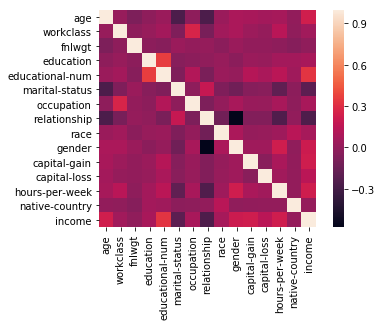

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
48838,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
48839,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
48840,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0
48841,52,5,287927,11,9,2,4,5,4,0,15024,0,40,39,1


In [31]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(income_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.tail(5)

In [32]:
# Expore the strong correaltion between "education" and "education-num" revealed by the heatmap
income_df[["education", "educational-num"]].head(10)

,education,educational-num
0,11th,7
1,HS-grad,9
2,Assoc-acdm,12
3,Some-college,10
4,Some-college,10
5,10th,6
6,HS-grad,9
7,Prof-school,15
8,Some-college,10
9,7th-8th,4


In [33]:
# "education" and "education-num" are essentially the same data, delete the categorical one
del income_df["education"]

In [34]:
income_df.head(1) # Successfully deleted!

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K


In [35]:
# Check the negative correlation between "gender" and "relationship"
income_df[["gender", "relationship"]].head(10)

,gender,relationship
0,Male,Own-child
1,Male,Husband
2,Male,Husband
3,Male,Husband
4,Female,Own-child
5,Male,Not-in-family
6,Male,Unmarried
7,Male,Husband
8,Female,Unmarried
9,Male,Husband


In [36]:
# It looks like "Female" and "wife" and anti-correlated, so are "Male" and "Husband"

In [37]:
encoded_data, encoders = number_encode_features(income_df)
new_series = encoded_data["income"]

In [46]:
# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("income")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [39]:
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

In [40]:
print accuracy_score(y_test, y_pred)

0.8246775404354058


In [47]:
# follow-up work: Try one hot encoding
